In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow_probability as tfp
from utils.plot import *
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions
tfb = tfp.bijectors

In [3]:
sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)
plt.rcParams['image.cmap'] = 'viridis'

# Model

In [4]:
class Squeeze3D(tfb.Bijector):
    def __init__(
        self,
        factor=2,
        forward_min_event_ndims=0,
        inverse_min_event_ndims=0,
        validate_args=False,
        name="Squeeze",
    ):
        self._factor = factor
        super(Squeeze3D, self).__init__(
            forward_min_event_ndims=forward_min_event_ndims,
            inverse_min_event_ndims=inverse_min_event_ndims,
            name=name,
            is_constant_jacobian=True,
        )

    @property
    def factor(self):
        return self._factor

    def _forward(self, x):
        (H, W, C) = x.shape[1:]
        batch_size = tf.shape(x)[0:1]
        tmp_shape = tf.concat(
            [
                batch_size,
                (H // self.factor, self.factor, W // self.factor, self.factor, C),
            ],
            axis=0,
        )
        output_shape = tf.concat(
            [
                batch_size,
                (H // self.factor, W // self.factor, C * self.factor**2)
            ],
            axis=0,
        )
        y = tf.reshape(x, tmp_shape)
        y = tf.transpose(y, [0, 1, 3, 5, 2, 4])
        y = tf.reshape(y, output_shape)
        return y

    def _inverse(self, y):
        (H, W, C) = y.shape[1:]
        batch_size = tf.shape(y)[0:1]
        tmp_shape = tf.concat([
            batch_size, (H, W, C // self.factor**2, self.factor, self.factor)
        ],
                              axis=0)
        output_shape = tf.concat([
            batch_size, (H * self.factor, W * self.factor, C // self.factor**2)
        ],
                                 axis=0)
        x = tf.reshape(y, tmp_shape)
        x = tf.transpose(x, [0, 1, 4, 2, 5, 3])
        x = tf.reshape(x, output_shape)
        return x

    def _forward_log_det_jacobian(self, x):
        return tf.constant(0.0, dtype=x.dtype)


def test_squeeze3D():
    factor = 2
    x = tf.Variable([[[1, 2, 5, 6], [3, 4, 7, 8], [9, 10, 13, 14],
                      [11, 12, 15, 16]]])
    x = tf.expand_dims(x, axis=-1)
    squeeze3d = Squeeze3D(factor=factor)
    y = squeeze3d.forward(x)
    z = squeeze3d.inverse(y)
    print(tf.reduce_sum(x - z))

    flow = tfd.TransformedDistribution(event_shape=[16, 16, 2],
                                       distribution=tfd.Normal(loc=0.,
                                                               scale=1.),
                                       bijector=squeeze3d)
    x = tf.random.normal([64, 32, 8, 8])
    y = flow.bijector.forward(x)
    log_prob = flow.log_prob(y)
    print(x.shape, y.shape, log_prob.shape)

In [5]:
def trainable_lu_factorization(event_size,
                               batch_shape=(),
                               seed=None,
                               dtype=tf.float32,
                               name=None):
    with tf.name_scope('trainable_lu_factorization'):
        event_size = tf.convert_to_tensor(event_size,
                                          dtype=tf.int32,
                                          name='event_size')
        batch_shape = tf.convert_to_tensor(batch_shape,
                                           dtype=event_size.dtype,
                                           name='batch_shape')
        random_matrix = tf.Variable(
            tf.random.uniform(
                shape=tf.concat([batch_shape, [event_size, event_size]], axis=0),
                dtype=dtype,
                seed=seed,
            ),
            name='conv1x1_weights',
        )

        def lu_p(m):
            return tf.linalg.lu(tf.linalg.qr(m).q)


        lower_upper = tf.Variable(lu_p(random_matrix)[0], name='lower_upper')
        permutation = tf.Variable(lu_p(random_matrix)[1], trainable=False, name='permutation')
        return lower_upper, permutation

In [6]:
class InvertibleConv1x1(tfb.Bijector):
    def __init__(self, input_shape, validate_args=False, name='inv_conv_1x1'):
        n_channels = input_shape[-1]
        self.conv1x1 = tfb.ScaleMatvecLU(
            *trainable_lu_factorization(n_channels), 
            validate_args=validate_args,
        )
        self.inv_conv1x1 = tfb.Invert(self.conv1x1)
        
        super(InvertibleConv1x1, self).__init__(
            forward_min_event_ndims=1,
            is_constant_jacobian=False,
            validate_args=validate_args,
            name=name,
        )
    
    def _forward(self, x):
        fwd = tfp.layers.DistributionLambda(lambda x: self.conv1x1(tfd.Deterministic(x)))
        fwd.vars = self.conv1x1.trainable_variables
        return fwd(x)
    
    def _inverse(self, y):
        inv = tfp.layers.DistributionLambda(lambda y: self.inv_conv1x1(tfd.Deterministic(y)))
        inv.vars = self.inv_conv1x1.trainable_variables
        return inv(y)
    
    def _inverse_log_det_jacobian(self, y):
        return -self._forward_log_det_jacobian(self._inverse(y))
    
    def _forward_log_det_jacobian(self, x):
        return self.conv1x1._forward_log_det_jacobian(x)

In [7]:
class AffineCoupling(tfb.Bijector):
    def __init__(self, input_shape, hidden_layers, flip=False, validate_args=False, name='affine_coupling'):
        # the internal nn is run over half the channels
        # thus the network input shape is different than usual
        n_channels = input_shape[-1] // 2
        inputs = tfkl.Input((*input_shape[:-1], n_channels))
        a = inputs
        for filters in hidden_layers:
            a = tfkl.Conv2D(
                filters=filters, 
                kernel_size=3,
                kernel_initializer='he_uniform',
                padding='same',
                activation='relu',
            )(a)
        
        log_scale = tfkl.Conv2D(
            filters=1, 
            kernel_size=3,
            kernel_initializer='zeros',
            padding='same', 
            activation='tanh',
        )(a)
        shift = tfkl.Conv2D(
            filters=1, 
            kernel_size=3,
            kernel_initializer='zeros',
            padding='same', 
        )(a)
        
        self.nn = tfk.models.Model(inputs=inputs, outputs=[log_scale, shift])
        self.flip = flip
    
        super(AffineCoupling, self).__init__(
            forward_min_event_ndims=1,
            is_constant_jacobian=False,
            validate_args=validate_args,
            name=name,
        )
        
    def _affine_scalar(self, x0):
        log_s, t = self.nn(x0)
        return tfb.AffineScalar(log_scale=log_s, shift=t)
    
    def _forward(self, x):
        x_a, x_b = tf.split(x, 2, axis=-1)
        
        if self.flip:
            x_a, x_b = x_b, x_a
            
        y_a = x_a
        y_b = self._affine_scalar(x_a).forward(x_b)
        y = tf.concat([y_a, y_b], axis=-1)
        return y
    
    def _inverse(self, y):
        y_a, y_b = tf.split(y, 2, axis=-1)
        if self.flip:
            y_a, y_b = y_b, y_a
        x_a = y_a
        x_b = self._affine_scalar(y_a).inverse(y_b)
        x = tf.concat([x_a, x_b], axis=-1)
        return x
    
    def _inverse_log_det_jacobian(self, y):
        return -self._forward_log_det_jacobian(self._inverse(y))
    
    def _forward_log_det_jacobian(self, x):
        _, x_b = tf.split(x, 2, axis=-1)
        log_s, _ = self.nn(x_b)
        return tf.reduce_sum(log_s)
    
    def summary(self):
        print(self.nn.summary())
        

## Image distribution (MNIST)

In [8]:
# Fetch and format the mnist data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
BATCH_SIZE = 1024

train_ds = tf.data.Dataset.from_tensor_slices(
  (tf.cast(x_train[...,tf.newaxis]/255, tf.float32)))\
    .shuffle(1000)\
    .batch(BATCH_SIZE)

eval_ds = tf.data.Dataset.from_tensor_slices(
  (tf.cast(x_test[...,tf.newaxis]/255, tf.float32)))\
    .batch(BATCH_SIZE)

In [38]:
def flow_step(input_shape, level, hidden_layers):
    tmp_shape = [
        input_shape[0] // 2,
        input_shape[1] // 2,
        input_shape[2] * 4 - level * 8
    ]
    return (
        Squeeze3D(),
        #tfb.BatchNormalization(),
        tfb.ScaleMatvecLU(*trainable_lu_factorization(tmp_shape[-1]),),
        AffineCoupling(input_shape=tmp_shape, hidden_layers=hidden_layers),
        tfb.Invert(Squeeze3D()),
       )

## Model setup

In [39]:
def negloglik(x, rv_x):
    return -tf.reduce_mean(rv_x.log_prob(x))

In [40]:
input_shape = (None, 28, 28, 1)

In [74]:
bijector_model = tfb.Chain(list(reversed([
    *flow_step(input_shape[1:], 0, (2, 2)),
])))

In [75]:
flow = tfd.TransformedDistribution(
    event_shape=[28,28,1],
    distribution=tfd.Normal(loc=0.0, scale=1.0),
    bijector=bijector_model,
)

In [79]:
opt = tf.optimizers.Adam(learning_rate=1e-4)
loss_obj = tf.keras.metrics.Mean(name='loss', dtype=tf.float32)

In [80]:
N_EPOCHS = 1

for cur_epoch in range(N_EPOCHS):
    with tqdm(total=len(train_ds)) as pbar:
        for x in train_ds:
            with tf.GradientTape() as tape:
                loss = negloglik(x, flow)
            loss_obj.update_state(loss)
            grads = tape.gradient(loss, flow.trainable_variables)
            opt.apply_gradients(zip(grads, flow.trainable_variables))
            pbar.set_postfix(loss=loss_obj.result().numpy())
            pbar.update(1)


100%|██████████| 59/59 [00:03<00:00, 15.17it/s, loss=-3.79e+6]


In [81]:
noise = tfd.Normal(loc=0, scale=1).sample((10, 28, 28, 1))

In [82]:
imgs = flow.bijector.inverse(noise)

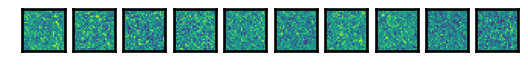

In [83]:
multiplot(
    [img.numpy().squeeze() for img in imgs]
)

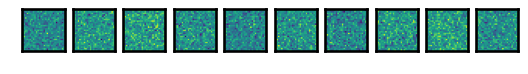

In [84]:
multiplot(
    [img.numpy().squeeze() for img in flow.sample(10)]
)

In [85]:
for xs_test in eval_ds.take(1):
    pass

In [86]:
idx1 = 30
idx2 = 21

inx1 = xs_test[idx1:idx1+1]
inx2 = xs_test[idx2:idx2+1]

inv1 = flow.bijector.inverse(inx1)
inv2 = flow.bijector.inverse(inx2)
mean_inv = tf.reduce_mean([inv1, inv2], axis=0)
mean_hat = flow.bijector.forward(mean_inv)

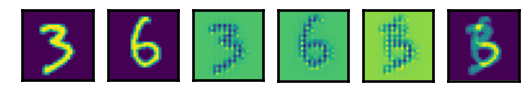

In [87]:
multiplot([
    img.numpy().squeeze() for img in [
        inx1,
        inx2,
        inv1,
        inv2,
        mean_inv,
        mean_hat,
    ]
])